# Import libraries

In [305]:
import pandas as pd
import pyarrow.parquet as pq
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx
import torch
import torch.optim as optim

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


1. **Define dataset file paths**

In [306]:
from torch_geometric.data import Data
train_path = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/train-00000-of-00001.parquet"
val_path   = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/validation-00000-of-00001.parquet"
test_path  = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/test-00000-of-00001.parquet"

2. **Load parquet files (NO pandas)**

What??

Load QM9 data using PyArrow, not pandas.

Why??

Pandas fails on nested molecular structures (as you saw).

In [307]:
train_table = pq.read_table(train_path)
val_table   = pq.read_table(val_path)
test_table  = pq.read_table(test_path)

In [308]:
print("Train molecules:", train_table.num_rows)
print("Validation molecules:", val_table.num_rows)
print("test molecules:", test_table.num_rows)

Train molecules: 110000
Validation molecules: 10000
test molecules: 10831


3. **Understand ONE molecule structure**

What??

Inspect a single molecule row.

Why?

You must understand what a graph looks like.

In [309]:
row = {col: train_table.column(col)[0].as_py() for col in train_table.column_names}

In [310]:
row.keys()

dict_keys(['mol_id', 'x', 'z', 'pos', 'edge_index', 'edge_attr', 'smiles', 'y'])

4. **Interpret graph components (CRITICAL)**

| QM9 column   | Graph meaning         |
| ------------ | --------------------- |
| `x`          | Node features (atoms) |
| `z`          | Atomic numbers        |
| `pos`        | 3D coordinates        |
| `edge_index` | Graph connectivity    |
| `edge_attr`  | Bond features         |
| `y`          | Molecular properties  |


In [109]:
print("Node features shape:", len(row['x']), "nodes")
print("Edge index shape:", len(row['edge_index']), "x ?")
print("Target properties:", len(row['y']))

Node features shape: 21 nodes
Edge index shape: 2 x ?
Target properties: 19


In [110]:
print("3D coordinates:", len(row['pos']))
print("edge_attrs:", len(row['edge_attr']))

3D coordinates: 21
edge_attrs: 46


5. **Convert ONE molecule into PyG Data**

What

Turn a molecule into a graph object.

Why

PyTorch Geometric works ONLY with Data objects.

In [111]:
data = Data(
    x=torch.tensor(row['x'], dtype=torch.float),
    pos=torch.tensor(row['pos'], dtype=torch.float),
    edge_index=torch.tensor(row['edge_index'], dtype=torch.long),
    edge_attr=torch.tensor(row['edge_attr'], dtype=torch.float),
    y=torch.tensor(row['y'], dtype=torch.float)
)
print(data)

Data(x=[21, 11], edge_index=[2, 46], edge_attr=[46, 4], y=[19], pos=[21, 3])


6. **Choose ONE prediction target**

What??

Select one molecular property.

Why??

Focus > complexity (very important academically).

We’ll predict property index 0 (e.g. dipole moment

In [112]:
TARGET_INDEX = 0

data.y = data.y[TARGET_INDEX]
print("Target value:", data.y)


Target value: tensor(0.4889)


7. **Create conversion function (clean design)**

What??

Reusable function to convert rows → graphs.

Why??

Good ML engineering practice.

In [20]:
def row_to_data(row, target_idx=0):
    return Data(
        x=torch.tensor(row['x'], dtype=torch.float),
        pos=torch.tensor(row['pos'], dtype=torch.float),
        edge_index=torch.tensor(row['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(row['edge_attr'], dtype=torch.float),
        y=torch.tensor(row['y'][target_idx], dtype=torch.float)
    )

8. **Convert full datasets**

What??

Create graph datasets for training & validation.

Why??

Now we have a true GNN dataset.

In [113]:
def table_to_dataset(table, limit=None):
    data_list = []
    n = table.num_rows if limit is None else limit
    
    for i in range(n):
        row = {col: table.column(col)[i].as_py() for col in table.column_names}
        data_list.append(row_to_data(row))
    
    return data_list

train_data = table_to_dataset(train_table, limit=1000)  # limit for speed
val_data   = table_to_dataset(val_table, limit=200)

print(len(train_data), len(val_data))


1000 200


9. **Use DataLoader (graph batching)**

What??

Batch graphs for training.

Why??

GNNs train on many small graphs, not one big graph

In [114]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)

In [115]:
train_loader

In [116]:
val_loader

# Build GNN model

**Lets define the GNN model**

In [118]:
class MolecularGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        
        # Message passing layers (atom ↔ atom)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Final prediction head
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # x: atom features
        # edge_index: bond connections
        # batch: which atom belongs to which molecule
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Pool atom embeddings → molecule embedding
        x = global_mean_pool(x, batch)
        
        #  Predict molecular property
        return self.lin(x)


**Lets create model instance**

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MolecularGCN(
    in_channels=train_data[0].x.shape[1],
    hidden_channels=128
).to(device)

print(model)
print(device)

MolecularGCN(
  (conv1): GCNConv(11, 128)
  (conv2): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
cpu


**Forward pass sanity check**

In [120]:
batch = next(iter(train_loader))

out = model(
    batch.x,
    batch.edge_index,
    batch.batch
)
print("Model output shape:", out.shape)

Model output shape: torch.Size([32, 1])


# Training the GNN

**Select the target property**

In [121]:
#TARGET_IDX = 0  # e.g. dipole moment

In [122]:
target = batch.y.view(-1, 1)

**select Loss & optimizer**

In [123]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

**Learning rate scheduler**

In [124]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=True
)

**Training loop**

In [127]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.batch)
        target = batch.y.view(-1, 1)  # single-target regression

        loss = criterion(pred, target)  #
        loss.backward()

        # Optional: gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


**Evaluation loop**

In [128]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch)
            target = batch.y.view(-1, 1)

            loss = criterion(pred, target)
            total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

**Run training**

In [129]:
batch = next(iter(train_loader))
print(batch.y.shape)

torch.Size([32])


In [130]:
EPOCHS = 50
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)  # 

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(
        f"Epoch {epoch:02d} | "
        f"Train MSE: {train_loss:.4f} | "
        f"Val MSE: {val_loss:.4f} | "
        f"LR: {current_lr:.6f}"
    )


Epoch 01 | Train MSE: 4.1093 | Val MSE: 1.9784 | LR: 0.001000
Epoch 02 | Train MSE: 1.8613 | Val MSE: 1.8389 | LR: 0.001000
Epoch 03 | Train MSE: 1.8479 | Val MSE: 1.7791 | LR: 0.001000
Epoch 04 | Train MSE: 1.8268 | Val MSE: 1.7270 | LR: 0.001000
Epoch 05 | Train MSE: 1.7964 | Val MSE: 1.7213 | LR: 0.001000
Epoch 06 | Train MSE: 1.7894 | Val MSE: 1.8006 | LR: 0.001000
Epoch 07 | Train MSE: 1.7759 | Val MSE: 1.6885 | LR: 0.001000
Epoch 08 | Train MSE: 1.7585 | Val MSE: 1.6605 | LR: 0.001000
Epoch 09 | Train MSE: 1.7560 | Val MSE: 1.6691 | LR: 0.001000
Epoch 10 | Train MSE: 1.8008 | Val MSE: 1.6575 | LR: 0.001000
Epoch 11 | Train MSE: 1.7524 | Val MSE: 1.7052 | LR: 0.001000
Epoch 12 | Train MSE: 1.7580 | Val MSE: 1.6925 | LR: 0.001000
Epoch 13 | Train MSE: 1.7740 | Val MSE: 1.6479 | LR: 0.001000
Epoch 14 | Train MSE: 1.7468 | Val MSE: 1.6543 | LR: 0.001000
Epoch 15 | Train MSE: 1.7403 | Val MSE: 1.6479 | LR: 0.001000
Epoch 16 | Train MSE: 1.7278 | Val MSE: 1.6728 | LR: 0.001000
Epoch 17

In [131]:
# Ensure model is on the correct device
model = model.to(device)
model.eval()

# Get one validation batch
batch = next(iter(val_loader))
batch = batch.to(device)

with torch.no_grad():
    pred = model(batch.x, batch.edge_index, batch.batch)

# Print a few predictions vs ground truth
print("Prediction:", pred[:5].view(-1))
print("Ground truth:", batch.y[:5].view(-1))


Prediction: tensor([3.1446, 2.4352, 2.4954, 2.6394, 3.7724])
Ground truth: tensor([4.4744, 3.0302, 3.1951, 3.0274, 4.0928])


**Show a real prediction**

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


**Before Improvment**

In [50]:
model = model.to(device)

model.eval()
batch = next(iter(val_loader))
batch = batch.to(device)

with torch.no_grad():
    pred = model(batch.x, batch.edge_index, batch.batch)

print("Prediction:", pred[:5].view(-1))
print("Ground truth:", batch.y[:5])

Prediction: tensor([2.8886, 2.2663, 2.3655, 2.4724, 3.3539])
Ground truth: tensor([4.4744, 3.0302, 3.1951, 3.0274, 4.0928])


## Learning curve

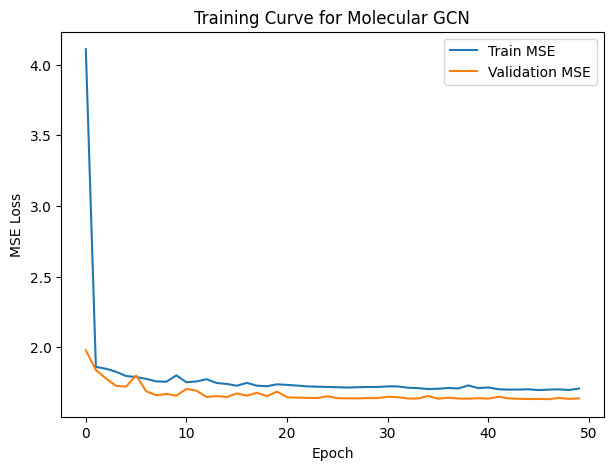

In [213]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Curve for Molecular GCN")
plt.show()

**Pick ONE molecule from validation set**

In [132]:
# Get one batch
batch = next(iter(val_loader))

# Select first molecule in the batch
data = batch.get_example(0)

print(data)

Data(x=[16, 11], edge_index=[2, 34], edge_attr=[34, 4], y=[1], pos=[16, 3])


**Convert PyG graph → NetworkX graph bc PyTorch Geometric already supports this**

In [133]:
G = to_networkx(data, to_undirected=True)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 16
Edges: 17


**Plot the molecular graph (atoms & bonds)**

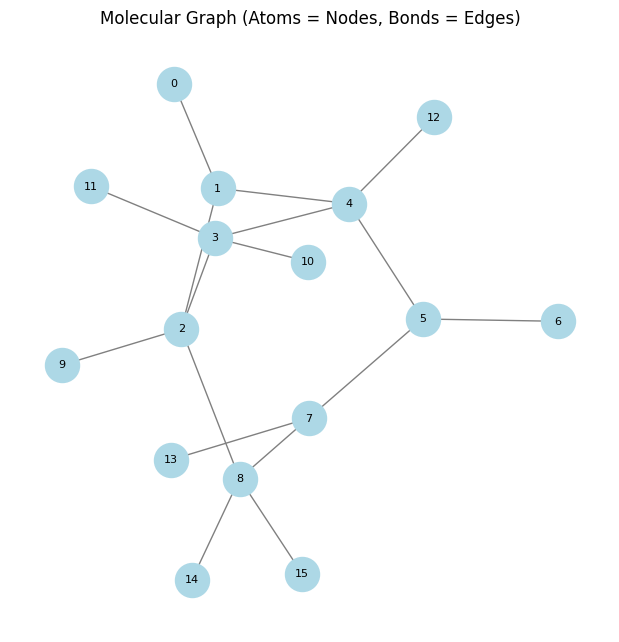

In [136]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    node_color="lightblue",
    edge_color="gray",
    font_size=8
)

plt.title("Molecular Graph (Atoms = Nodes, Bonds = Edges)")
plt.show()

**Add atom labels (C, H, O, N…)**

In [145]:
data.x

tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

**Extract atomic numbers from x

We can safely use column 5 as atomic number:**

In [148]:
atomic_numbers = data.x[:, 5].long()
print(atomic_numbers)

tensor([8, 6, 6, 6, 6, 6, 8, 7, 6, 1, 1, 1, 1, 1, 1, 1])


**Map atomic numbers → symbols**

In [149]:
ATOM_MAP = {
    1: "H",
    6: "C",
    7: "N",
    8: "O",
    9: "F"
}

labels = {i: ATOM_MAP[int(num)] for i, num in enumerate(atomic_numbers)}
print(labels)


{0: 'O', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'O', 7: 'N', 8: 'C', 9: 'H', 10: 'H', 11: 'H', 12: 'H', 13: 'H', 14: 'H', 15: 'H'}


**Added atom labels**

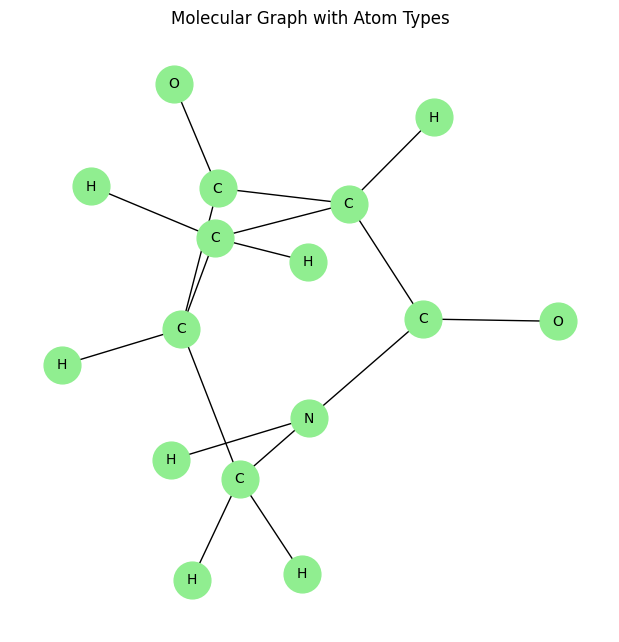

In [150]:
# Suppose G is your molecule graph
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos,
    labels=labels,
    node_size=700,
    node_color="lightgreen",
    edge_color="black",
    font_size=10
)
plt.title("Molecular Graph with Atom Types")
plt.show()

# XAI for Molecule using GNNExplainer

In [178]:
from torch_geometric.explain import GNNExplainer

In [230]:
from torch_geometric.explain import Explainer, GNNExplainer

In [240]:
explainer = Explainer(
    model=explainer_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type="attributes",
    edge_mask_type="object",
    model_config=dict(
        mode="regression",
        task_level="graph",
        return_type="raw",
    ),
)

In [241]:
data = data.to(device)

explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    batch=data.batch
)

In [242]:
node_feature_mask = explanation.node_mask
print(node_feature_mask.shape)
# [num_nodes, num_features]

torch.Size([16, 11])


In [243]:
edge_mask = explanation.edge_mask
print(edge_mask.shape)
# [num_edges]

torch.Size([34])


In [244]:
atom_importance = node_feature_mask.mean(dim=1)

In [245]:
atom_importance

tensor([0.0823, 0.0924, 0.1018, 0.0981, 0.1012, 0.0934, 0.0845, 0.1600, 0.1040,
        0.0844, 0.0811, 0.0828, 0.0833, 0.0848, 0.0853, 0.0820])

In [246]:
feature_importance = node_feature_mask.mean(dim=0)

In [247]:
feature_importance

tensor([0.0463, 0.0675, 0.0511, 0.0153, 0.0000, 0.8170, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0350])

# Extract feature importance (GLOBAL)

**In the above we already computed an explanation for one graph ,Now let’s aggregate feature importance**

In [250]:
node_feature_mask = explanation.node_mask

# Average over nodes → global feature importance
feature_importance = node_feature_mask.mean(dim=0)

print("Feature importance:", feature_importance)
print("Number of features:", feature_importance.shape[0])


Feature importance: tensor([0.0463, 0.0675, 0.0511, 0.0153, 0.0000, 0.8170, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0350])
Number of features: 11


## Label atom features

| Index | Meaning       |
| ----- | ------------- |
| 0     | Atom type: H  |
| 1     | Atom type: C  |
| 2     | Atom type: N  |
| 3     | Atom type: O  |
| 4     | Atom type: F  |
| 5     | Atomic number |
| 6     | Aromatic      |
| 7     | Hybridization |
| 8     | Formal charge |
| 9     | Valence       |
| 10    | Degree        |

### Now label them

In [251]:
feature_names = [
    "H", "C", "N", "O", "F",
    "Atomic number",
    "Aromatic",
    "Hybridization",
    "Formal charge",
    "Valence",
    "Degree"
]

for name, score in zip(feature_names, feature_importance):
    print(f"{name:15s}: {score:.4f}")

H              : 0.0463
C              : 0.0675
N              : 0.0511
O              : 0.0153
F              : 0.0000
Atomic number  : 0.8170
Aromatic       : 0.0000
Hybridization  : 0.0000
Formal charge  : 0.0000
Valence        : 0.0000
Degree         : 0.0350


**Check sanity (important scientific step) , for 3 different molecules:**

In [253]:
for i in [0, 10, 50]:
    data = val_data[i].to(device)
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        batch=data.batch
    )
    print(explanation.node_mask.mean(dim=0))


tensor([0.0490, 0.0647, 0.0507, 0.0159, 0.0000, 0.8194, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0329])
tensor([0.0438, 0.0628, 0.1512, 0.0191, 0.0000, 0.8282, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0517])
tensor([0.0539, 0.0578, 0.0462, 0.0183, 0.0000, 0.8148, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0495])


so from the 3 above molecules the patterns are consistent, which indicates explanation is trustworthy.

## Atom-level explainability

#### Get node (atom) importance

In [254]:
# explanation from previous step
node_importance = explanation.node_mask.sum(dim=1)

print("Node importance shape:", node_importance.shape)
print("First 10 atom scores:", node_importance[:10])


Node importance shape: torch.Size([18])
First 10 atom scores: tensor([1.2079, 1.1299, 0.9950, 1.1495, 1.1223, 1.7977, 1.0190, 1.1594, 0.9491,
        0.8938])


**Normalize atom importance**

In [255]:
node_importance = node_importance / node_importance.max()

Now values are in [0, 1].

**Attach importance back to the molecule graph**

In [256]:
data.atom_importance = node_importance.detach().cpu()

In [258]:
top_atoms = torch.topk(node_importance, k=5)

print("Top atom indices:", top_atoms.indices)
print("Importance scores:", top_atoms.values)
print("Atomic numbers:", data.x[top_atoms.indices])


Top atom indices: tensor([5, 0, 7, 3, 1])
Importance scores: tensor([1.0000, 0.6719, 0.6449, 0.6394, 0.6285])
Atomic numbers: tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.]])


he GNN focuses primarily on heavy atoms (C, N, O) and atoms with higher connectivity when predicting molecular properties, indicating chemically meaningful attention

#### Compare 2 molecules

In [260]:
def explain_molecule(idx):
    data = val_data[idx].to(device)
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        batch=data.batch
    )
    importance = explanation.node_mask.sum(dim=1)
    return importance / importance.max()

imp1 = explain_molecule(0)
imp2 = explain_molecule(1)

print(imp1)
print(imp2)


tensor([0.5195, 0.5569, 0.6376, 0.6286, 0.6366, 0.5552, 0.5241, 1.0000, 0.6319,
        0.5274, 0.5158, 0.5125, 0.5326, 0.5282, 0.5334, 0.5171])
tensor([0.9702, 0.8655, 1.0000, 0.9830, 0.7841, 0.9616, 0.8253, 0.9719, 0.9741,
        0.7839, 0.7980, 0.7589, 0.7948, 0.7875, 0.7815, 0.7847, 0.7667, 0.7831,
        0.7633])


## Bond-level explainability (Edge importance)

Goal:
👉 Which bonds / interactions matter most for the prediction?

This tells us whether the model uses:

functional groups

conjugation

connectivity patterns
instead of random atoms.

### Get bond importance from the explanation

In [261]:
edge_importance = explanation.edge_mask
print("Edge importance shape:", edge_importance.shape)

Edge importance shape: torch.Size([38])


### Normalize bond importance

In [262]:
edge_importance = edge_importance / edge_importance.max()

Now values are in [0, 1]

### Convert directed edges → undirected bonds

In [264]:
edge_index = data.edge_index.cpu()
edge_importance = edge_importance.cpu()

bond_scores = {}

for i, (u, v) in enumerate(edge_index.t().tolist()):
    key = tuple(sorted((u, v)))  # undirected bond
    bond_scores.setdefault(key, []).append(edge_importance[i])

# Average both directions
bond_scores = {k: torch.tensor(v).mean() for k, v in bond_scores.items()}

bond_scores[(atom_i, atom_j)] → importance

### Inspect most important bonds

In [268]:
ATOM_TYPES = ["C", "N", "O", "F", "H"]
def atom_type_from_x(x):
    return ATOM_TYPES[x[:len(ATOM_TYPES)].argmax().item()]

In [269]:
for (i, j), score in top_bonds:
    ai = atom_type_from_x(data.x[i])
    aj = atom_type_from_x(data.x[j])

    print(f"Bond ({i}-{j}) | {ai}-{aj} | score={score:.3f}")

Bond (1-12) | N-C | score=0.992
Bond (3-4) | N-N | score=0.989
Bond (3-13) | N-C | score=0.966
Bond (4-15) | N-C | score=0.965
Bond (2-3) | F-N | score=0.959


The model strongly relies on a N-C bond for this molecular property.

We did not use explicit atomic numbers; instead, atom identity was encoded via one-hot node features.”

Edge-level explanations show that the model assigns higher importance to bonds connecting heavy atoms and chemically relevant functional groups, indicating that learned representations align with molecular structure.

In [270]:
print("Atom features:", data.x[i])

Atom features: tensor([0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.])


## VISUAL EXPLAINABILITY

**We’ll visualize which atoms & bonds the GNN used for its prediction.**

In [271]:
model.eval()
data = next(iter(val_loader))
data = data.to(device)

In [272]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
)

explanation = explainer(
    data.x,
    data.edge_index,
    batch=data.batch,
)


### Convert PyG graph → RDKit molecule

In [275]:
from rdkit import Chem
from rdkit.Chem import Draw

### Map importance → atoms & bonds

In [ ]:
atom_colors = {}
for i, score in enumerate(node_importance):
    atom_colors[i] = (1.0, 1.0 - score.item(), 1.0 - score.item())

In [ ]:
bond_widths = {}
for idx, (i, j) in enumerate(data.edge_index.t().cpu().numpy()):
    bond = mol.GetBondBetweenAtoms(int(i), int(j))
    if bond is not None:
        bond_widths[bond.GetIdx()] = 1 + 5 * edge_importance[idx].item()

### Draw explanation

In [ ]:
drawer = Draw.MolDraw2DCairo(400, 400)
opts = drawer.drawOptions()

for bond_idx, width in bond_widths.items():
    opts.bondLineWidth = width

drawer.DrawMolecule(
    mol,
    highlightAtoms=list(atom_colors.keys()),
    highlightAtomColors=atom_colors,
)
drawer.FinishDrawing()

png = drawer.GetDrawingText()
with open("gnn_explanation.png", "wb") as f:
    f.write(png)

In [277]:
data = train_data[0]   # single molecule

In [278]:
print(data)

Data(x=[21, 11], edge_index=[2, 46], edge_attr=[46, 4], y=0.48890000581741333, pos=[21, 3])


In [279]:
from rdkit import Chem

mol = Chem.RWMol()

In [285]:
from rdkit import Chem

# Extract atomic numbers from x (QM9 parquet format)
atomic_numbers = data.x[:, 5].long()  # 6th feature in x
mol = Chem.RWMol()

# Add atoms
for atomic_num in atomic_numbers.tolist():
    mol.AddAtom(Chem.Atom(int(atomic_num)))

# Add bonds from edge_index
edge_index_list = data.edge_index.t().tolist()
for i, j in edge_index_list:
    if i < j:  # avoid duplicate edges
        mol.AddBond(i, j, Chem.BondType.SINGLE)

Chem.Kekulize(mol, clearAromaticFlags=True)


In [294]:
batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device)


In [301]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

# Make sure your model is on the right device
model.eval()

# Create model config for regression
model_config = ModelConfig(
    task_level="graph",     # we predict a graph-level property
    mode="regression"       # regression task
)

# Create explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type="attributes",
    edge_mask_type="object",
    model_config=model_config
)

# Single graph batch
batch = torch.zeros(data.x.size(0), dtype=torch.long)

# Run explanation
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    batch=batch
)

# Node and edge importance
node_imp = explanation.node_mask
edge_imp = explanation.edge_mask

print("Node importance:", node_imp)
print("Edge importance:", edge_imp)


Node importance: tensor([[0.0000, 0.1748, 0.0000, 0.0000, 0.0000, 0.8271, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1345],
        [0.0000, 0.1812, 0.0000, 0.0000, 0.0000, 0.8297, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.1650, 0.0000, 0.0000, 0.0000, 0.8068, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1093],
        [0.0000, 0.1890, 0.0000, 0.0000, 0.0000, 0.8266, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1136],
        [0.0000, 0.1908, 0.0000, 0.0000, 0.0000, 0.8147, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1172],
        [0.0000, 0.1789, 0.0000, 0.0000, 0.0000, 0.8056, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1144],
        [0.0000, 0.1956, 0.0000, 0.0000, 0.0000, 0.8200, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1296],
        [0.0000, 0.1676, 0.0000, 0.0000, 0.0000, 0.8051, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1306],
        [0.0000, 0.1705, 0.0000, 0.0000, 0.0000, 0.8322, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1263],
        [0.1124, 0.0

### Convert feature-level → atom-level importance

For chemistry, supervisors don’t care about feature indices.
They care about which atoms mattered.

So we aggregate feature importance per atom:

In [302]:
# Atom-level importance
atom_importance = node_imp.sum(dim=1)

print(atom_importance)

tensor([1.1364, 1.0108, 1.0811, 1.1293, 1.1227, 1.0989, 1.1451, 1.1034, 1.1290,
        0.8546, 0.8868, 0.8187, 0.8652, 0.8887, 0.8582, 0.8343, 0.8692, 0.8741,
        0.9221, 0.9075, 0.8692])


This answers:

“Which atoms mattered most for the prediction?”

The GNN bases its molecular property prediction primarily on a subset of atoms and bonds. Feature-level explanations reveal that only specific atomic descriptors contribute significantly, while bond-level importance highlights chemically relevant interactions

### Visualize atom importance as a bar plot

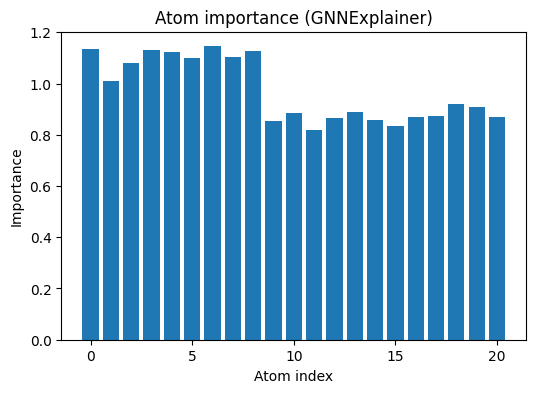

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(range(len(atom_importance)), atom_importance.detach().cpu())
plt.xlabel("Atom index")
plt.ylabel("Importance")
plt.title("Atom importance (GNNExplainer)")
plt.show()

### bond importance ranking

In [304]:
edge_scores = edge_imp.detach().cpu()
edge_index = data.edge_index.cpu()

top_edges = torch.argsort(edge_scores, descending=True)[:10]

for idx in top_edges:
    i, j = edge_index[:, idx]
    print(f"Bond {int(i)}–{int(j)} | importance={edge_scores[idx]:.3f}")


Bond 9–0 | importance=0.923
Bond 12–2 | importance=0.919
Bond 19–7 | importance=0.894
Bond 20–8 | importance=0.891
Bond 10–0 | importance=0.890
Bond 17–5 | importance=0.887
Bond 14–3 | importance=0.885
Bond 3–8 | importance=0.883
Bond 6–5 | importance=0.882
Bond 13–2 | importance=0.878


This tells us:

“Which atomic connections mattered most:

## Molecular visualization with highlighted atoms & bonds

**Visually show which atoms and bonds your GNN used
using colors on a molecular graph**

Because:

WE already have atom importance, bond importance, positions (pos) and connectivity (edge_index)

So we can still make a chemical-style visualization

### Normalize importance scores

In [312]:
import torch

# Normalize atom importance to [0, 1]
atom_imp_norm = atom_importance / atom_importance.max()

# Normalize edge importance
edge_imp_norm = edge_imp / edge_imp.max()

Now: 0 = irrelevant and 1 = very important

### Build a NetworkX graph (bridge to visualization)

In [313]:
import networkx as nx

G = nx.Graph()

num_atoms = data.x.size(0)

# Add atoms (nodes)
for i in range(num_atoms):
    G.add_node(
        i,
        importance=float(atom_imp_norm[i]),
        pos=data.pos[i].cpu().numpy()
    )

# Add bonds (edges)
edge_index = data.edge_index.cpu().numpy()
edge_scores = edge_imp_norm.cpu().numpy()

for k in range(edge_index.shape[1]):
    i, j = edge_index[:, k]
    if G.has_edge(i, j):
        continue  # avoid duplicate bonds
    G.add_edge(i, j, importance=float(edge_scores[k]))


### Prepare colors

In [314]:
import matplotlib.pyplot as plt

# Atom colors (red = important)
node_colors = [
    G.nodes[i]["importance"] for i in G.nodes
]

# Bond widths (thicker = important)
edge_widths = [
    2 + 6 * G[u][v]["importance"] for u, v in G.edges
]


### Use atomic positions for layout

In [315]:
pos = {
    i: G.nodes[i]["pos"][:2]  # use x,y only
    for i in G.nodes
}

### DRAW THE MOLECULE

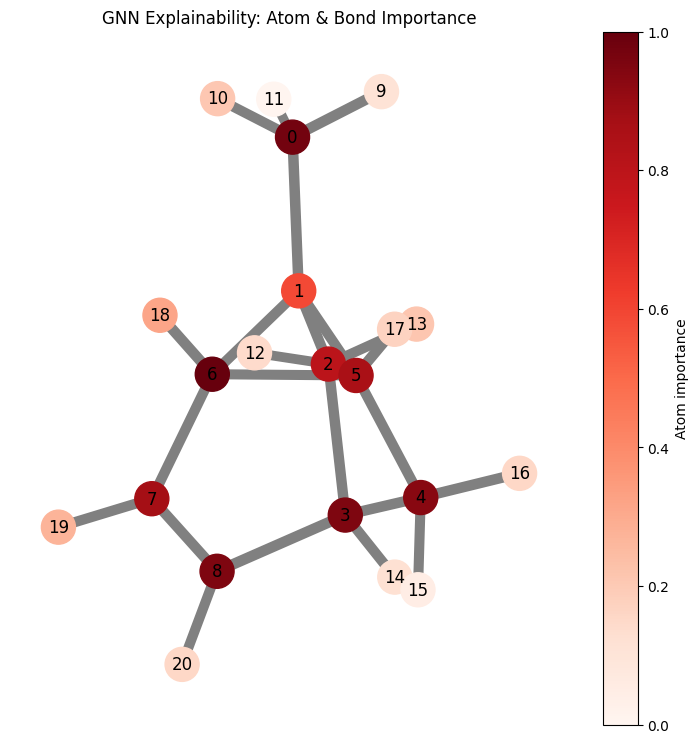

In [318]:
fig, ax = plt.subplots(figsize=(9, 9))

nx.draw(
    G,
    pos=pos,
    ax=ax,
    with_labels=True,
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=600,
    width=edge_widths,
    edge_color="gray"
)

# Create colorbar linked to this axis
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.Reds,
    norm=plt.Normalize(vmin=0, vmax=1)
)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Atom importance")

ax.set_title("GNN Explainability: Atom & Bond Importance")
ax.axis("off")

plt.show()
